<a href="https://colab.research.google.com/github/thomasjuin1/EmotionClassification/blob/twitter-dataset/LSTM_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN (LSTM cell) for emotion recognition
In this python notebook we will see how to classify the emotion of a text using a RecurentNeuralNetwork.
We will work on the [emotion](https://huggingface.co/datasets/dair-ai/emotion/viewer/unsplit) dataset.



In [12]:
!pip install datasets

In [11]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random

In [13]:
def split_dataset(dataset, train_ratio: float = 0.8,
                  test_ratio: float = 0.1,
                  val_ratio: float = 0.1):
    length = len(dataset["train"])
    # shuffle the dataset
    dataset["train"] = dataset["train"].shuffle()
    train_set = dataset["train"].select(range(int(length * train_ratio)))
    test_set = dataset["train"].select(range(int(length * train_ratio), int(length * (train_ratio + test_ratio))))
    val_set = dataset["train"].select(range(int(length * (train_ratio + test_ratio)), length))

    return train_set, test_set, val_set

def load_twitter_dataset(split = "split"):
    if split not in ["split", "unsplit"]:
        raise ValueError("split must be either 'split' or 'unsplit'")
    ds = load_dataset("dair-ai/emotion", split)

    # Get the train, validation and test sets
    train_set, test_set, val_set = None, None, None

    if split == "split":
        train_set = ds["train"]
        test_set = ds["test"]
        val_set = ds["validation"]
    else:
        # Split the training, validation and test sets, because the "unsplit" dataset only has a training set
        train_set, test_set, val_set = split_dataset(ds)

    # Make sure the dataset is in the right format and in memory
    train_set = train_set.map(lambda x: {"text": x["text"], "label": x["label"]})
    test_set = test_set.map(lambda x: {"text": x["text"], "label": x["label"]})
    val_set = val_set.map(lambda x: {"text": x["text"], "label": x["label"]})

    emotions = [
        "sadness",
        "joy",
        "love",
        "anger",
        "fear",
        "surprise",
    ]


    return train_set, test_set, val_set, emotions

def load_goemotions_dataset(split = "simplified"):
    if split not in ["simplified", "raw"]:
        raise ValueError("split must be either 'simplified' or 'raw'")
    emotions = [
        "admiration",
        "amusement",
        "anger",
        "annoyance",
        "approval",
        "caring",
        "confusion",
        "curiosity",
        "desire",
        "disappointment",
        "disapproval",
        "disgust",
        "embarrassment",
        "excitement",
        "fear",
        "gratitude",
        "grief",
        "joy",
        "love",
        "nervousness",
        "optimism",
        "pride",
        "realization",
        "relief",
        "remorse",
        "sadness",
        "surprise",
        "neutral",
    ]
    ds = load_dataset("google-research-datasets/go_emotions", split)

    train_set, test_set, val_set = None, None, None

    if split == "simplified":
        # Get the train and test sets
        train_set = ds["train"]
        test_set = ds["test"]
        val_set = ds["validation"]

        train_set = train_set.map(lambda x: {"text": x["text"], "label": x["labels"][random.randint(0, len(x["labels"])-1)]})
        test_set = test_set.map(lambda x: {"text": x["text"], "label": x["labels"][random.randint(0, len(x["labels"])-1)]})
        val_set = val_set.map(lambda x: {"text": x["text"], "label": x["labels"][random.randint(0, len(x["labels"])-1)]})
    else:
        # Get the train, validation and test sets
        train_set, test_set, val_set = split_dataset(ds)

        # the google dataset raw labels are not stored in a list, but rather there are multiple keys: 'admiration', 'amusement', etc.
        # where if it is present, the value is 1, otherwise it is 0
        # so we need to convert this to a list of labels
        def row_to_label(row):
            for i in range(len(emotions)):
                if row[emotions[i]] == 1:
                    return i


        # Make sure the dataset is in the right format and in memory
        train_set = train_set.map(lambda x: {"text": x["text"], "label": row_to_label(x)})
        test_set = test_set.map(lambda x: {"text": x["text"], "label": row_to_label(x)})
        val_set = val_set.map(lambda x: {"text": x["text"], "label": row_to_label(x)})

    # remove rows that have no label
    # train_set = train_set.filter(lambda x: x["label"] != None)
    # test_set = test_set.filter(lambda x: x["label"] != None)
    # val_set = val_set.filter(lambda x: x["label"] != None)

    return train_set, test_set, val_set, emotions


# train_set, test_set, val_set, __emotions = load_twitter_dataset("split")
google_train_set, google_test_set, google_val_set, google__emotions = load_goemotions_dataset("simplified")
train_set, test_set, val_set, __emotions = google_train_set, google_test_set, google_val_set, google__emotions

EMOTION_TO_INDEX = {
    emotion: index for index, emotion in enumerate(__emotions)
}

INDEX_TO_EMOTION = {
    index: emotion for emotion, index in EMOTION_TO_INDEX.items()
}


KeyboardInterrupt: 

Those list and dict will be used later in the program for translation.

## Pre-process the dataset
Before using the dataset, we need to pre-process it.

We will:

Remove the stopwords
Remove the punctuation
Lemmatize the text
Convert the text to lowercase
We will pre-process the training dataset, for it to be ready to train on.
The encode function ensure a sequence of fix size (usefule for a lot of things batch for eg.)

In [3]:
import spacy
from collections import Counter
from multiprocess import Pool

nlp = spacy.load("en_core_web_sm")

def preprocess(text: str) -> list[str]:
    """
    This function remove stop word, lemmatize the token of the text, lowercase it

    Args:
      text: The text to preprocess

    Returns:
      A tokenize version of the text
    """
    tokens = nlp(text)
    return preprocess_doc(tokens)

def preprocess_doc(doc):
    return [token.lemma_.lower().strip() for token in doc if not token.like_url and not token.is_stop]

def build_vocab(texts: list[str], max_vocab_size: int) -> dict[str, int]:
    """
    Builds a vocabulary mapping tokens to unique indices from a list of texts.
    - The vocabulary is constructed based on token frequency, keeping the most common tokens
      up to the specified `max_vocab_size`.
    - Tokens beyond `max_vocab_size` are excluded from the vocabulary.

    Args:
        texts (list[str]): A list of input texts to be tokenized and processed.
        max_vocab_size (int): The maximum size of the vocabulary, including special tokens.

    Returns:
        dict[str, int]: A dictionary where:
            - Keys are tokens (words).
            - Values are unique integer indices.
            Special tokens included:
            - "<PAD>": 0 (used for padding).
            - "<UNK>": 1 (used for unknown tokens).
            Other tokens are assigned indices starting from 2.


    """
    print("Number of texts: ", len(texts))
    with Pool() as p:
        preprocessed_texts = p.map(preprocess_doc, nlp.pipe(texts, batch_size=1024, n_process=8))
        counter = Counter(token for tokens in preprocessed_texts for token in tokens)
    # counter = Counter(token for text in texts for token in preprocess(text))
    most_common: list[tuple[str, int]] = counter.most_common(max_vocab_size - 2)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}  # Reserve 0 and 1
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab, preprocessed_texts

def encode(text: str, vocab: dict[str, int], max_len: int) -> list[int]:
    """
    Encodes a text into a fixed-length sequence of token IDs using a given vocabulary.

    Args:
        text: The input text to be tokenized and encoded.
        vocab (dict[str, int: A dictionary mapping tokens to their corresponding IDs.
            Special tokens:
            - "<PAD>": ID used for padding.
            - "<UNK>": ID used for unknown tokens.
        max_len (int): The maximum length of the encoded sequence. Longer sequences are truncated,
            and shorter sequences are padded.

    Returns:
        list[int]: A list of token IDs representing the encoded text, with a fixed length of `max_len`.
    """

    tokens = preprocess(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) > max_len:
        return ids[:max_len]
    return ids + [vocab["<PAD>"]] * (max_len - len(ids))

# Build vocabulary
all_texts = train_set["text"]
VOCAB_SIZE = 15000
MAX_LEN = 50
vocab, pre_processed_train_texts = build_vocab(all_texts, VOCAB_SIZE)

Number of texts:  43410


Vocabulary size: 15000


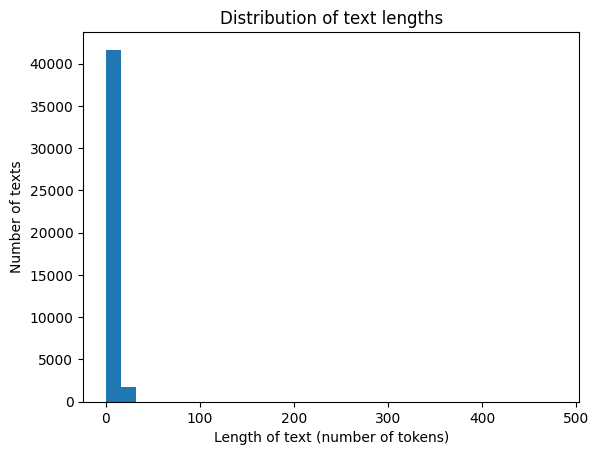

In [27]:
print("Vocabulary size:", len(vocab))

# plot the distribution of the length of the text
import matplotlib.pyplot as plt

text_lengths = [len(text) for text in pre_processed_train_texts]
plt.hist(text_lengths, bins=30)
plt.xlabel("Length of text (number of tokens)")
plt.ylabel("Number of texts")
plt.title("Distribution of text lengths")
plt.show()

We create a Dataset class that inherit from pytorch Dataset object, to use Dataloader

In [4]:
def tensor_encode(text: str, vocab: dict[str, int], max_len: int) -> torch.Tensor:
    base = torch.tensor(encode(text, vocab, max_len), dtype=torch.long)
    return base

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

        self.processed_texts = []
        with Pool() as p:
            self.processed_texts = p.map(lambda x: tensor_encode(x, vocab, max_len), texts)
        self.processed_labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.processed_texts[idx],
            "labels": self.processed_labels[idx],
        }

# Prepare datasets
train_dataset = EmotionDataset(train_set["text"], train_set["label"], vocab, MAX_LEN)
val_dataset = EmotionDataset(val_set["text"], val_set["label"], vocab, MAX_LEN)
test_dataset = EmotionDataset(test_set["text"], test_set["label"], vocab, MAX_LEN)

In [5]:
# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_set["label"]))  # Number of unique emotions

## Create the LSTM model
In the next cell create we our model

With 4 layer: (5 if we count dropout)
- embedings (batch_size, seq_length)
- LSTM (batch_size, seq_length, embed_dim)
- Mean Pooling (batch_size, seq_length, hidden_dim)
- fully conected (batch_size, hidden_dim) -> (batch_size, NUM_CLASSES)

In [6]:

class LSTM(nn.Module):
    def __init__(self, embed_dim: int, hidden_dim: int, dropout_p: float = 0.1, *, bidirectional: bool = True, with_attention: bool = True):
        super(LSTM, self).__init__()
        self.with_attention = with_attention
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)

        if bidirectional:
            hidden_dim *= 2

        if with_attention:
            self.attention = nn.MultiheadAttention(hidden_dim, num_heads=1)

        self.fc = nn.Linear(hidden_dim, NUM_CLASSES)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = self.dropout(self.embedding(x))
        x, _ = self.lstm(x)
        if self.with_attention:
            x, _ = self.attention(x, x, x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

use_gpu = torch.cuda.is_available()
DEVICE = 'cuda' if use_gpu else 'cpu'
print(f"Using : {DEVICE}")

model = LSTM(embed_dim=32, hidden_dim=64, dropout_p=0.2)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0007, weight_decay=0.05)

Using : cuda


## Training
In this cell we train our model and we can evaluate
along the training to see if our model is doing good
(This task can be long 20min on T4 GPU for split dataset)

In [9]:
from copy import deepcopy

def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                epochs,
                doEvaluate,
                *,
                scheduler = None,
                verbose = True
                ) -> None:
    """
    This function tain the model and validat along the way if the parameter doEvaluate is true
    """
    print("Training the model") if verbose else None
    best_model = None
    best_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader) if verbose else train_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)


            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        if doEvaluate:
          model.eval()
          val_loss = 0
          val_preds, val_labels = [], []
          total_preds = 0
          total_correct = 0
          with torch.no_grad():
            #   print ("Validating the model") if verbose else None
              for batch in val_loader:
                  input_ids = batch["input_ids"].to(DEVICE)
                  labels = batch["labels"].to(DEVICE)

                  outputs = model(input_ids)
                  loss = criterion(outputs, labels)
                  val_loss += loss.item()

                  preds = torch.argmax(outputs, dim=1).cpu().numpy()
                  val_preds.extend(preds)
                  val_labels.extend(labels.cpu().numpy())

                  total_preds += len(preds)
                  total_correct += (preds == labels.cpu().numpy()).sum()

          if val_loss < best_loss:
              best_loss = val_loss
              best_model = deepcopy(model)

          print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {total_correct / total_preds:.4f}") if verbose else None
        else:
          print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}") if verbose else None
    return best_model

best_model = train_model(model, train_loader, val_loader, criterion, optimizer, 10, True)

Training the model


  0%|          | 0/1357 [00:00<?, ?it/s]

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Evaluation Time
In the two next celle we are gonna evaluate the model with two differnet graphics

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def get_model_performance(model, data_loader, index_to_emotion, device):
    """
    Evaluate the model and compute accuracy per emotion.

    Args:
        model: The trained model.
        data_loader: DataLoader for the evaluation set.
        index_to_emotion: A dictionary mapping label indices to emotion names.
        device: The device to run the evaluation on.

    Returns:
        A dictionary with emotion-wise accuracy and a plot.
    """
    model.eval()
    emotion_correct = defaultdict(int)
    emotion_total = defaultdict(int)
    total_predictions = defaultdict(int)

    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Update emotion-specific counts
            for true_label, pred_label in zip(labels, preds):
                true_emotion = index_to_emotion[true_label]
                predicted_emotion = index_to_emotion[pred_label]
                emotion_total[true_emotion] += 1
                true_labels.append(true_emotion)
                predicted_labels.append(predicted_emotion)
                total_predictions[true_emotion] += 1
                if true_emotion == predicted_emotion:
                    emotion_correct[true_emotion] += 1
                else:
                    false_positives[predicted_emotion] += 1
                    false_negatives[true_emotion] += 1

     # Calculate accuracy, recall, precision and F1 score for each emotion
    metrics = {}
    for label in __emotions:
        tp = emotion_correct[label]
        fp = false_positives[label]
        fn = false_negatives[label]

        # Calculate precision
        precision = tp / (tp + fp) if tp + fp > 0 else 0

        # Calculate recall
        recall = tp / (tp + fn) if tp + fn > 0 else 0

        # Calculate F1 score
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        metrics[label] = {
            "accuracy": emotion_correct[label] / total_predictions[label],
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score
        }

    # Calculate total accuracy
    total_accuracy = sum(emotion_correct.values()) / sum(total_predictions.values())

    return metrics, total_accuracy, true_labels, predicted_labels

def evaluate_model(model, data_loader, index_to_emotion, device, title="Model Performance"):
    metrics, total_accuracy, true_labels, predicted_labels = get_model_performance(
        model, data_loader, index_to_emotion, device
    )

    # Plot accuracy per emotion
    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), [metric["accuracy"] * 100 for metric in metrics.values()])
    plt.title("Accuracy per Emotion", fontsize=16)
    plt.xlabel("Emotion", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xticks(rotation=90)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig("accuracy_per_emotion.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

    disp = ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, labels=__emotions, normalize="true", cmap="Blues")
    fig = disp.figure_
    fig.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight", transparent=True)
    # uncomment for a larger plot
    # fig = disp.figure_
    # fig.set_figwidth(40)
    # fig.set_figheight(40)
    # # disp.plot(cmap="Blues")
    # disp.im_.set_clim(0, 1)
    # plt.title(title)
    # plt.xticks(rotation=60)
    # plt.show()

    # Create a table of metrics
    metrics_table = []
    for emotion, metric in metrics.items():
        metrics_table.append([emotion, f"{metric['accuracy']:.2f}", f"{metric['precision']:.2f}", f"{metric['recall']:.2f}", f"{metric['f1_score']:.2f}"])
    metrics_table.append(["Total", f"{total_accuracy:.2f}", "", "", ""])
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    # plot table, adding a little height padding
    plt.table(cellText=metrics_table, colLabels=["Emotion", "Accuracy", "Precision", "Recall", "F1 Score"], cellLoc="center", loc="center")
    plt.title(title, fontsize=15)
    plt.show()

    # Print the results
    print(f"Overall Accuracy: {total_accuracy:.2f}%")
    for emotion, metric in metrics.items():
        print(f"{emotion.capitalize()}:")
        print(f"  - Accuracy: {metric['accuracy']:.2f}")
        print(f"  - Precision: {metric['precision']:.2f}")
        print(f"  - Recall: {metric['recall']:.2f}")
        print(f"  - F1 Score: {metric['f1_score']:.2f}")
        print()

    return total_accuracy

# Evaluate the trained model
evaluate_model(
    model=best_model,
    data_loader=test_loader,
    index_to_emotion=INDEX_TO_EMOTION,
    device=DEVICE
)

Evaluating:   0%|          | 0/170 [00:00<?, ?it/s]

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import time

def grid_search():
    embed_dims = [32, 64, 128]
    hidden_dims = {
        32: [32, 64],
        64: [64, 128],
        128: [128, 256]
    }
    dropout_rates = [0.1, 0.2, 0.3]
    learning_rates = [0.001, 0.0007, 0.0005]
    weight_decays = [0, 0.01, 0.05, 0.1]
    with_attention = [True]
    bidi = [True]
    batch_sizes = [32, 64, 128]

    params = [(embed_dim, hidden_dim, dropout_rate, lr, wd, bs)
              for embed_dim in embed_dims
              for hidden_dim in hidden_dims[embed_dim]
              for dropout_rate in dropout_rates
              for lr in learning_rates
              for wd in weight_decays
            for bs in batch_sizes]

    print(f"Total number of combinations: {len(params)}")
    best_accuracy = 0
    best_params = None
    avg_time_taken = 0
    num_runs = 0
    for embed_dim, hidden_dim, dropout_rate, lr, wd, bs in params:
        start = time.time()
        model = LSTM(embed_dim=embed_dim, hidden_dim=hidden_dim, dropout_p=dropout_rate)
        model.to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2000, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False)

        trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, 30, True, verbose=False)
        metrics, accuracy, true_labels, predicted_labels = get_model_performance(trained_model, test_loader, INDEX_TO_EMOTION, DEVICE)[0]
        print(f"Accuracy: {accuracy:.2f}% for params: {embed_dim=}, {hidden_dim=}, {dropout_rate=}, {lr=}, {wd=}, {bs=}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (embed_dim, hidden_dim, dropout_rate, lr, wd)
        end = time.time()
        time_taken = end - start
        avg_time_taken *= num_runs
        avg_time_taken += end - start
        num_runs += 1
        avg_time_taken /= num_runs
        print(f"Time taken: {time_taken:.2f}s, estimated time left: {avg_time_taken * (len(params) - num_runs) / 60:.2f}min")

    print(f"Best accuracy: {best_accuracy:.2f}%")
    print(f"Best parameters: {best_params}")

grid_search()

Total number of combinations: 648


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0, bs=32
Time taken: 50.50s, estimated time left: 544.58min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0, bs=64
Time taken: 35.54s, estimated time left: 463.21min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 74.80% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0, bs=128
Time taken: 18.15s, estimated time left: 373.37min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.01, bs=32
Time taken: 53.74s, estimated time left: 423.80min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.01, bs=64
Time taken: 29.21s, estimated time left: 401.12min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.30% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.01, bs=128
Time taken: 16.51s, estimated time left: 363.19min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.35% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.05, bs=32
Time taken: 56.58s, estimated time left: 397.16min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.05, bs=64
Time taken: 34.43s, estimated time left: 392.89min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.05, bs=128
Time taken: 20.03s, estimated time left: 372.38min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.95% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.1, bs=32
Time taken: 67.02s, estimated time left: 405.88min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.1, bs=64
Time taken: 39.00s, estimated time left: 406.05min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 78.95% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.001, wd=0.1, bs=128
Time taken: 19.95s, estimated time left: 389.26min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.30% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0, bs=32
Time taken: 66.75s, estimated time left: 413.09min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.55% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0, bs=64
Time taken: 35.41s, estimated time left: 409.71min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 50.80% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0, bs=128
Time taken: 22.11s, estimated time left: 397.34min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.50% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=32
Time taken: 66.46s, estimated time left: 415.67min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 75.15% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=64
Time taken: 37.83s, estimated time left: 414.00min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 68.40% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=128
Time taken: 20.63s, estimated time left: 402.41min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=32
Time taken: 67.34s, estimated time left: 417.78min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.90% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=64
Time taken: 39.26s, estimated time left: 416.81min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 71.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=128
Time taken: 22.04s, estimated time left: 407.29min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=32
Time taken: 63.46s, estimated time left: 418.25min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.50% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=64
Time taken: 36.16s, estimated time left: 415.81min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 50.35% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=128
Time taken: 20.24s, estimated time left: 406.62min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 78.15% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0, bs=32
Time taken: 62.34s, estimated time left: 415.62min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 71.45% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0, bs=64
Time taken: 34.41s, estimated time left: 412.71min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 70.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0, bs=128
Time taken: 18.66s, estimated time left: 403.94min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 76.20% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=32
Time taken: 60.26s, estimated time left: 411.12min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 72.30% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=64
Time taken: 34.81s, estimated time left: 408.69min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 46.50% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=128
Time taken: 16.77s, estimated time left: 400.19min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=32
Time taken: 57.68s, estimated time left: 405.78min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 75.40% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=64
Time taken: 33.12s, estimated time left: 403.09min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 61.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=128
Time taken: 19.35s, estimated time left: 396.25min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 80.40% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=32
Time taken: 61.57s, estimated time left: 402.50min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 71.80% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=64
Time taken: 31.55s, estimated time left: 399.58min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 69.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=128
Time taken: 19.73s, estimated time left: 393.44min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0, bs=32
Time taken: 65.13s, estimated time left: 400.10min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0, bs=64
Time taken: 29.86s, estimated time left: 396.92min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 80.45% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0, bs=128
Time taken: 16.19s, estimated time left: 390.33min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.50% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.01, bs=32
Time taken: 56.96s, estimated time left: 394.37min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.65% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.01, bs=64
Time taken: 33.84s, estimated time left: 392.47min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.01, bs=128
Time taken: 20.92s, estimated time left: 387.53min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.05, bs=32
Time taken: 54.50s, estimated time left: 390.67min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.65% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.05, bs=64
Time taken: 29.51s, estimated time left: 387.91min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.20% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.05, bs=128
Time taken: 19.60s, estimated time left: 383.04min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.55% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.1, bs=32
Time taken: 64.50s, estimated time left: 388.16min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.90% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.1, bs=64
Time taken: 34.81s, estimated time left: 386.69min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.55% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.001, wd=0.1, bs=128
Time taken: 19.55s, estimated time left: 382.08min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.30% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0, bs=32
Time taken: 60.71s, estimated time left: 386.02min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 62.20% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0, bs=64
Time taken: 33.44s, estimated time left: 384.34min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 76.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0, bs=128
Time taken: 18.85s, estimated time left: 379.85min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=32
Time taken: 59.78s, estimated time left: 383.34min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 76.55% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=64
Time taken: 33.24s, estimated time left: 381.69min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 69.65% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=128
Time taken: 19.13s, estimated time left: 377.50min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.45% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=32
Time taken: 61.16s, estimated time left: 381.01min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.20% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=64
Time taken: 34.18s, estimated time left: 379.59min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 80.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=128
Time taken: 19.25s, estimated time left: 375.63min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.1, bs=32
Time taken: 60.39s, estimated time left: 378.77min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.20% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.1, bs=64
Time taken: 32.90s, estimated time left: 377.19min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 73.40% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0007, wd=0.1, bs=128
Time taken: 18.84s, estimated time left: 373.35min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0, bs=32
Time taken: 60.16s, estimated time left: 376.26min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 53.90% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0, bs=64
Time taken: 33.31s, estimated time left: 374.80min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 65.80% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0, bs=128
Time taken: 18.35s, estimated time left: 371.07min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 60.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.01, bs=32
Time taken: 58.50s, estimated time left: 373.54min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 56.20% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.01, bs=64
Time taken: 32.25s, estimated time left: 371.98min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 52.95% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.01, bs=128
Time taken: 18.00s, estimated time left: 368.36min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.05, bs=32
Time taken: 58.84s, estimated time left: 370.75min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.05, bs=64
Time taken: 34.30s, estimated time left: 369.54min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 69.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.05, bs=128
Time taken: 19.34s, estimated time left: 366.26min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.1, bs=32
Time taken: 57.47s, estimated time left: 368.32min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.1, bs=64
Time taken: 31.77s, estimated time left: 366.80min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 64.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.2, lr=0.0005, wd=0.1, bs=128
Time taken: 18.21s, estimated time left: 363.51min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.40% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0, bs=32
Time taken: 58.40s, estimated time left: 365.57min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0, bs=64
Time taken: 32.21s, estimated time left: 364.17min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0, bs=128
Time taken: 18.64s, estimated time left: 361.06min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.05% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.01, bs=32
Time taken: 57.47s, estimated time left: 362.90min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.00% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.01, bs=64
Time taken: 31.77s, estimated time left: 361.49min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 57.55% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.01, bs=128
Time taken: 18.17s, estimated time left: 358.44min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.90% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.05, bs=32
Time taken: 57.90s, estimated time left: 360.23min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.05% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.05, bs=64
Time taken: 32.05s, estimated time left: 358.90min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.05, bs=128
Time taken: 18.44s, estimated time left: 356.00min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.80% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.1, bs=32
Time taken: 58.41s, estimated time left: 357.75min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.15% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.1, bs=64
Time taken: 32.32s, estimated time left: 356.49min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 57.40% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.001, wd=0.1, bs=128
Time taken: 18.05s, estimated time left: 353.64min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.00% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0, bs=32
Time taken: 57.09s, estimated time left: 355.16min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 46.35% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0, bs=64
Time taken: 31.64s, estimated time left: 353.85min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 64.90% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0, bs=128
Time taken: 18.04s, estimated time left: 351.10min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.40% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.01, bs=32
Time taken: 58.10s, estimated time left: 352.66min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.80% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.01, bs=64
Time taken: 32.23s, estimated time left: 351.44min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 72.95% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.01, bs=128
Time taken: 18.55s, estimated time left: 348.83min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.55% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.05, bs=32
Time taken: 58.38s, estimated time left: 350.34min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 64.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.05, bs=64
Time taken: 32.19s, estimated time left: 349.15min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 72.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.05, bs=128
Time taken: 18.09s, estimated time left: 346.57min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.15% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.1, bs=32
Time taken: 59.18s, estimated time left: 348.08min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.95% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.1, bs=64
Time taken: 32.14s, estimated time left: 346.92min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 72.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0007, wd=0.1, bs=128
Time taken: 18.47s, estimated time left: 344.45min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 76.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0, bs=32
Time taken: 58.23s, estimated time left: 345.80min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 56.55% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0, bs=64
Time taken: 32.49s, estimated time left: 344.69min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 46.85% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0, bs=128
Time taken: 18.81s, estimated time left: 342.32min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 63.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.01, bs=32
Time taken: 58.00s, estimated time left: 343.58min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 52.45% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.01, bs=64
Time taken: 31.92s, estimated time left: 342.44min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 52.50% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.01, bs=128
Time taken: 17.95s, estimated time left: 340.06min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.70% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.05, bs=32
Time taken: 57.91s, estimated time left: 341.25min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 66.60% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.05, bs=64
Time taken: 32.14s, estimated time left: 340.15min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 56.10% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.05, bs=128
Time taken: 18.24s, estimated time left: 337.87min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.25% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.1, bs=32
Time taken: 59.59s, estimated time left: 339.14min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 54.75% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.1, bs=64
Time taken: 32.83s, estimated time left: 338.12min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 46.90% for params: embed_dim=32, hidden_dim=32, dropout_rate=0.3, lr=0.0005, wd=0.1, bs=128
Time taken: 18.93s, estimated time left: 335.94min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.20% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0, bs=32
Time taken: 59.18s, estimated time left: 337.12min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.55% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0, bs=64
Time taken: 33.08s, estimated time left: 336.14min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.70% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0, bs=128
Time taken: 25.67s, estimated time left: 334.56min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.15% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.01, bs=32
Time taken: 60.75s, estimated time left: 335.80min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.15% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.01, bs=64
Time taken: 33.74s, estimated time left: 334.87min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.60% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.01, bs=128
Time taken: 25.71s, estimated time left: 333.32min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.85% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.05, bs=32
Time taken: 61.14s, estimated time left: 334.52min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.25% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.05, bs=64
Time taken: 34.02s, estimated time left: 333.62min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.40% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.05, bs=128
Time taken: 25.80s, estimated time left: 332.10min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.15% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.1, bs=32
Time taken: 59.78s, estimated time left: 333.14min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.35% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.1, bs=64
Time taken: 33.33s, estimated time left: 332.18min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.00% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.1, bs=128
Time taken: 25.72s, estimated time left: 330.68min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.40% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0, bs=32
Time taken: 60.22s, estimated time left: 331.70min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.70% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0, bs=64
Time taken: 33.72s, estimated time left: 330.78min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 57.35% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0, bs=128
Time taken: 26.07s, estimated time left: 329.32min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.50% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=32
Time taken: 60.89s, estimated time left: 330.33min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.20% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=64
Time taken: 33.13s, estimated time left: 329.37min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.40% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=128
Time taken: 25.74s, estimated time left: 327.91min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.55% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=32
Time taken: 60.01s, estimated time left: 328.81min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=64
Time taken: 34.22s, estimated time left: 327.93min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.55% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=128
Time taken: 26.10s, estimated time left: 326.51min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.35% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=32
Time taken: 60.70s, estimated time left: 327.41min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.80% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=64
Time taken: 33.55s, estimated time left: 326.49min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.50% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=128
Time taken: 25.68s, estimated time left: 325.06min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.95% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0, bs=32
Time taken: 59.80s, estimated time left: 325.85min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 80.20% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0, bs=64
Time taken: 33.50s, estimated time left: 324.93min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 73.60% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0, bs=128
Time taken: 25.62s, estimated time left: 323.52min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.70% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=32
Time taken: 60.66s, estimated time left: 324.32min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.25% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=64
Time taken: 34.57s, estimated time left: 323.47min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 66.45% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=128
Time taken: 26.02s, estimated time left: 322.10min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.80% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=32
Time taken: 60.68s, estimated time left: 322.86min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 75.55% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=64
Time taken: 33.80s, estimated time left: 321.97min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 53.45% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=128
Time taken: 26.19s, estimated time left: 320.63min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=32
Time taken: 59.86s, estimated time left: 321.30min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.30% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=64
Time taken: 34.39s, estimated time left: 320.44min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 69.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=128
Time taken: 25.85s, estimated time left: 319.10min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.90% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0, bs=32
Time taken: 61.22s, estimated time left: 319.81min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.65% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0, bs=64
Time taken: 33.92s, estimated time left: 318.93min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.55% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0, bs=128
Time taken: 25.72s, estimated time left: 317.59min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.30% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.01, bs=32
Time taken: 60.67s, estimated time left: 318.23min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.90% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.01, bs=64
Time taken: 33.69s, estimated time left: 317.34min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.15% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.01, bs=128
Time taken: 25.79s, estimated time left: 316.02min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.55% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.05, bs=32
Time taken: 61.34s, estimated time left: 316.66min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.95% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.05, bs=64
Time taken: 34.32s, estimated time left: 315.81min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 74.95% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.05, bs=128
Time taken: 26.01s, estimated time left: 314.52min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.65% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.1, bs=32
Time taken: 61.79s, estimated time left: 315.15min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.60% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.1, bs=64
Time taken: 33.54s, estimated time left: 314.26min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.1, bs=128
Time taken: 25.93s, estimated time left: 312.98min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0, bs=32
Time taken: 60.20s, estimated time left: 313.49min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.20% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0, bs=64
Time taken: 34.37s, estimated time left: 312.65min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.60% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0, bs=128
Time taken: 26.00s, estimated time left: 311.38min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 76.70% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=32
Time taken: 62.68s, estimated time left: 311.98min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 74.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=64
Time taken: 36.03s, estimated time left: 311.23min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 78.80% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=128
Time taken: 26.22s, estimated time left: 309.98min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.40% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=32
Time taken: 60.63s, estimated time left: 310.45min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=64
Time taken: 33.50s, estimated time left: 309.57min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.10% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=128
Time taken: 25.88s, estimated time left: 308.32min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.20% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.1, bs=32
Time taken: 62.72s, estimated time left: 308.87min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.15% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.1, bs=64
Time taken: 34.12s, estimated time left: 308.02min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 73.80% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.1, bs=128
Time taken: 25.93s, estimated time left: 306.78min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.50% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0, bs=32
Time taken: 61.09s, estimated time left: 307.22min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 80.95% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0, bs=64
Time taken: 33.61s, estimated time left: 306.35min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 76.70% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0, bs=128
Time taken: 25.68s, estimated time left: 305.11min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.01, bs=32
Time taken: 60.77s, estimated time left: 305.51min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 80.10% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.01, bs=64
Time taken: 35.05s, estimated time left: 304.71min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.10% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.01, bs=128
Time taken: 25.75s, estimated time left: 303.49min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.65% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.05, bs=32
Time taken: 63.07s, estimated time left: 303.96min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 73.65% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.05, bs=64
Time taken: 34.77s, estimated time left: 303.15min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 50.90% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.05, bs=128
Time taken: 25.88s, estimated time left: 301.94min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.1, bs=32
Time taken: 60.58s, estimated time left: 302.27min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 55.45% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.1, bs=64
Time taken: 33.99s, estimated time left: 301.43min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 74.15% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.2, lr=0.0005, wd=0.1, bs=128
Time taken: 25.74s, estimated time left: 300.23min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0, bs=32
Time taken: 61.42s, estimated time left: 300.58min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.70% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0, bs=64
Time taken: 34.70s, estimated time left: 299.77min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 69.40% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0, bs=128
Time taken: 26.20s, estimated time left: 298.60min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.80% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.01, bs=32
Time taken: 62.59s, estimated time left: 298.97min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.90% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.01, bs=64
Time taken: 34.06s, estimated time left: 298.13min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.10% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.01, bs=128
Time taken: 25.94s, estimated time left: 296.96min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.20% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.05, bs=32
Time taken: 61.21s, estimated time left: 297.25min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.05, bs=64
Time taken: 34.44s, estimated time left: 296.43min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.25% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.05, bs=128
Time taken: 26.21s, estimated time left: 295.28min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.10% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.1, bs=32
Time taken: 63.29s, estimated time left: 295.63min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.10% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.1, bs=64
Time taken: 33.97s, estimated time left: 294.79min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.00% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.001, wd=0.1, bs=128
Time taken: 25.90s, estimated time left: 293.64min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0, bs=32
Time taken: 61.33s, estimated time left: 293.89min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0, bs=64
Time taken: 34.38s, estimated time left: 293.07min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.90% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0, bs=128
Time taken: 26.12s, estimated time left: 291.94min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.01, bs=32
Time taken: 62.04s, estimated time left: 292.19min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.50% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.01, bs=64
Time taken: 35.57s, estimated time left: 291.43min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.70% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.01, bs=128
Time taken: 25.80s, estimated time left: 290.29min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.15% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.05, bs=32
Time taken: 61.51s, estimated time left: 290.50min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.00% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.05, bs=64
Time taken: 33.91s, estimated time left: 289.67min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 72.40% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.05, bs=128
Time taken: 25.77s, estimated time left: 288.54min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.25% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.1, bs=32
Time taken: 61.92s, estimated time left: 288.75min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 78.80% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.1, bs=64
Time taken: 35.08s, estimated time left: 287.96min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 67.65% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0007, wd=0.1, bs=128
Time taken: 26.07s, estimated time left: 286.85min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.45% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0, bs=32
Time taken: 61.61s, estimated time left: 287.03min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 62.20% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0, bs=64
Time taken: 35.00s, estimated time left: 286.24min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 51.25% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0, bs=128
Time taken: 25.76s, estimated time left: 285.13min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 78.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.01, bs=32
Time taken: 72.65s, estimated time left: 285.68min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.65% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.01, bs=64
Time taken: 37.58s, estimated time left: 284.98min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 78.35% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.01, bs=128
Time taken: 26.87s, estimated time left: 283.91min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.10% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.05, bs=32
Time taken: 66.40s, estimated time left: 284.21min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 55.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.05, bs=64
Time taken: 37.14s, estimated time left: 283.50min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 56.40% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.05, bs=128
Time taken: 26.62s, estimated time left: 282.43min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.75% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.1, bs=32
Time taken: 66.35s, estimated time left: 282.70min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 78.05% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.1, bs=64
Time taken: 36.73s, estimated time left: 281.97min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 58.30% for params: embed_dim=32, hidden_dim=64, dropout_rate=0.3, lr=0.0005, wd=0.1, bs=128
Time taken: 26.01s, estimated time left: 280.89min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.80% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0, bs=32
Time taken: 62.79s, estimated time left: 281.02min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.55% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0, bs=64
Time taken: 37.63s, estimated time left: 280.32min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.35% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0, bs=128
Time taken: 27.91s, estimated time left: 279.30min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.20% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.01, bs=32
Time taken: 60.16s, estimated time left: 279.34min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.20% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.01, bs=64
Time taken: 33.03s, estimated time left: 278.49min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.75% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.01, bs=128
Time taken: 26.82s, estimated time left: 277.44min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.95% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.05, bs=32
Time taken: 57.49s, estimated time left: 277.37min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.25% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.05, bs=64
Time taken: 35.96s, estimated time left: 276.62min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.75% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.05, bs=128
Time taken: 27.49s, estimated time left: 275.60min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.10% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.1, bs=32
Time taken: 57.19s, estimated time left: 275.51min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.15% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.1, bs=64
Time taken: 32.28s, estimated time left: 274.65min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.00% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.001, wd=0.1, bs=128
Time taken: 26.58s, estimated time left: 273.61min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.00% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0, bs=32
Time taken: 60.74s, estimated time left: 273.62min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.70% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0, bs=64
Time taken: 34.44s, estimated time left: 272.82min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.95% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0, bs=128
Time taken: 27.50s, estimated time left: 271.82min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.90% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=32
Time taken: 66.08s, estimated time left: 271.97min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.00% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=64
Time taken: 39.52s, estimated time left: 271.33min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.90% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.01, bs=128
Time taken: 28.58s, estimated time left: 270.36min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.65% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=32
Time taken: 75.35s, estimated time left: 270.77min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.05% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=64
Time taken: 40.50s, estimated time left: 270.15min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 77.50% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.05, bs=128
Time taken: 28.31s, estimated time left: 269.17min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.10% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=32
Time taken: 64.69s, estimated time left: 269.25min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.55% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=64
Time taken: 35.36s, estimated time left: 268.47min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 83.30% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0007, wd=0.1, bs=128
Time taken: 27.97s, estimated time left: 267.49min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.80% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0, bs=32
Time taken: 61.25s, estimated time left: 267.45min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.20% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0, bs=64
Time taken: 33.38s, estimated time left: 266.63min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 75.05% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0, bs=128
Time taken: 27.70s, estimated time left: 265.65min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.20% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=32
Time taken: 67.04s, estimated time left: 265.76min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 79.35% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=64
Time taken: 44.53s, estimated time left: 265.24min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.40% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.01, bs=128
Time taken: 28.76s, estimated time left: 264.29min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.75% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=32
Time taken: 69.13s, estimated time left: 264.43min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 84.05% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=64
Time taken: 38.49s, estimated time left: 263.74min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.15% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.05, bs=128
Time taken: 28.81s, estimated time left: 262.80min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.25% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=32
Time taken: 86.28s, estimated time left: 263.38min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 80.65% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=64
Time taken: 45.90s, estimated time left: 262.88min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 72.05% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.1, lr=0.0005, wd=0.1, bs=128
Time taken: 27.87s, estimated time left: 261.91min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.35% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0, bs=32
Time taken: 63.27s, estimated time left: 261.86min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.85% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0, bs=64
Time taken: 38.23s, estimated time left: 261.16min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.40% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0, bs=128
Time taken: 26.91s, estimated time left: 260.16min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.20% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.01, bs=32
Time taken: 69.62s, estimated time left: 260.27min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.05% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.01, bs=64
Time taken: 38.68s, estimated time left: 259.57min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.85% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.01, bs=128
Time taken: 28.38s, estimated time left: 258.62min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 89.45% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.05, bs=32
Time taken: 72.66s, estimated time left: 258.78min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.25% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.05, bs=64
Time taken: 38.05s, estimated time left: 258.07min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.60% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.05, bs=128
Time taken: 28.09s, estimated time left: 257.11min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.15% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.1, bs=32
Time taken: 66.06s, estimated time left: 257.09min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 90.10% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.1, bs=64
Time taken: 36.65s, estimated time left: 256.34min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.75% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.001, wd=0.1, bs=128
Time taken: 27.52s, estimated time left: 255.38min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.25% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0, bs=32
Time taken: 69.97s, estimated time left: 255.43min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 86.75% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0, bs=64
Time taken: 42.41s, estimated time left: 254.82min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 81.55% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0, bs=128
Time taken: 28.28s, estimated time left: 253.88min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.30% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=32
Time taken: 61.78s, estimated time left: 253.73min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.45% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=64
Time taken: 34.55s, estimated time left: 252.93min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 87.65% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.01, bs=128
Time taken: 28.17s, estimated time left: 251.99min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 88.90% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=32
Time taken: 63.89s, estimated time left: 251.87min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 85.90% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=64
Time taken: 49.67s, estimated time left: 251.43min


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 82.40% for params: embed_dim=64, hidden_dim=64, dropout_rate=0.2, lr=0.0007, wd=0.05, bs=128
Time taken: 29.98s, estimated time left: 250.53min
